<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Qiskit Finance: Pricing Fixed-Income Assets*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>, Shaohan Hu<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ

### Introduction

We seek to price a fixed-income asset knowing the distributions describing the relevant interest rates. The cash flows $c_t$ of the asset and the dates at which they occur are known. The total value $V$ of the asset is thus the expectation value of:

$$V = \sum_{t=1}^T \frac{c_t}{(1+r_t)^t}$$

Each cash flow is treated as a zero coupon bond with a corresponding interest rate $r_t$ that depends on its maturity. The user must specify the distribution modelling the uncertainty in each $r_t$ (possibly correlated) as well as the number of qubits he wishes to use to sample each distribution. In this example we expand the value of the asset to first order in the interest rates $r_t$. This corresponds to studying the asset in terms of its duration.
<br>
<br>
The approximation of the objective function follows the following paper:<br>
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import BasicAer
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.ae import AmplitudeEstimation
from qiskit.aqua.components.uncertainty_models import MultivariateNormalDistribution
from qiskit.aqua.components.uncertainty_problems import FixedIncomeExpectedValue

In [2]:
backend = BasicAer.get_backend('statevector_simulator')

### Uncertainty Model

We construct a circuit factory to load a multivariate normal random distribution in $d$ dimensions into a quantum state.
The distribution is truncated to a given box $\otimes_{i=1}^d [low_i, high_i]$ and discretized using $2^{n_i}$ grid points, where $n_i$ denotes the number of qubits used for dimension $i = 1,\ldots, d$.
The unitary operator corresponding to the circuit factory implements the following: 
$$\big|0\rangle_{n_1}\ldots\big|0\rangle_{n_d} \mapsto \big|\psi\rangle = \sum_{i_1=0}^{2^n_-1}\ldots\sum_{i_d=0}^{2^n_-1} \sqrt{p_{i_1,...,i_d}}\big|i_1\rangle_{n_1}\ldots\big|i_d\rangle_{n_d},$$
where $p_{i_1, ..., i_d}$ denote the probabilities corresponding to the truncated and discretized distribution and where $i_j$ is mapped to the right interval $[low_j, high_j]$ using the affine map:
$$ \{0, \ldots, 2^{n_{j}}-1\} \ni i_j \mapsto \frac{high_j - low_j}{2^{n_j} - 1} * i_j + low_j \in [low_j, high_j].$$

In addition the the uncertainty model, we can also apply an affine map, e.g. resulting from a principal componant analyis. The interest rates used are then given by:
$$ \vec{r} = A * \vec{x} + b,$$
where $\vec{x} \in \otimes_{i=1}^d [low_i, high_i]$ follows the given random distribution.

In [3]:
# can be used in case a principal component analysis has been done to derive the uncertainty model, ignored in this example.
A = np.eye(2)
b = np.zeros(2) 

# specify the number of qubits that are used to represent the different dimenions of the uncertainty model
num_qubits = [2, 2]

# specify the lower and upper bounds for the different dimension
low = [0, 0]
high = [0.12, 0.24]
mu = [0.12, 0.24]
sigma = 0.01*np.eye(2)

# construct corresponding distribution
u = MultivariateNormalDistribution(num_qubits, low, high, mu, sigma)

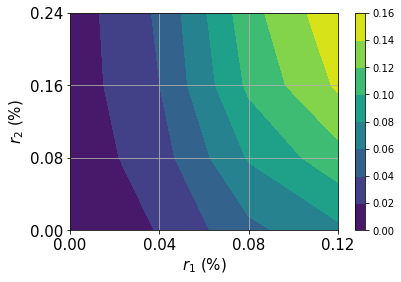

In [4]:
# plot contour of probability density function
x = np.linspace(low[0], high[0], 2**num_qubits[0])
y = np.linspace(low[1], high[1], 2**num_qubits[1])
z = u.probabilities.reshape(2**num_qubits[0], 2**num_qubits[1])
plt.contourf(x, y, z)
plt.xticks(x, size=15)
plt.yticks(y, size=15)
plt.grid()
plt.xlabel('$r_1$ (%)', size=15)
plt.ylabel('$r_2$ (%)', size=15)
plt.colorbar()
plt.show()

### Cash flow, payoff function, and exact expected value

In the following we define the cash flow per period, the resulting payoff function and evaluate the exact expected value.

For the payoff function we first use a first order approximation and then apply the same approximation technique as for the linear part of the payoff function of the [European Call Option](european_call_option_pricing.ipynb).

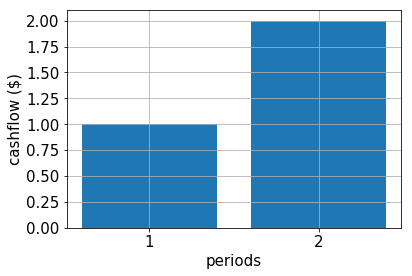

In [5]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf)+1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods, size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel('periods', size=15)
plt.ylabel('cashflow ($)', size=15)
plt.show()

In [6]:
# estimate real value
cnt = 0
exact_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            # evaluate linear approximation of real value w.r.t. interest rates
            exact_value += prob * (cf[t]/pow(1 + b[t], t+1) - (t+1)*cf[t]*np.dot(A[:, t], np.asarray([x1, x2]))/pow(1 + b[t], t+2))
        cnt += 1
print('Exact value:    \t%.4f' % exact_value)

Exact value:    	2.1942


In [7]:
# specify approximation factor
c_approx = 0.125

# get fixed income circuit appfactory
fixed_income = FixedIncomeExpectedValue(u, A, b, cf, c_approx)

In [8]:
# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, fixed_income)

In [9]:
# result = ae.run(quantum_instance=LegacySimulators.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=backend)

In [10]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	2.1942
Estimated value:	2.4600
Probability:    	0.8487


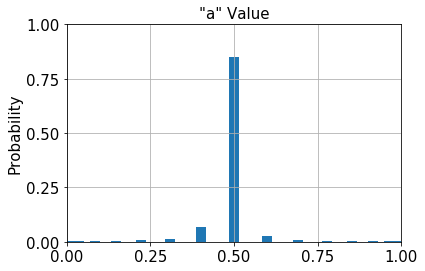

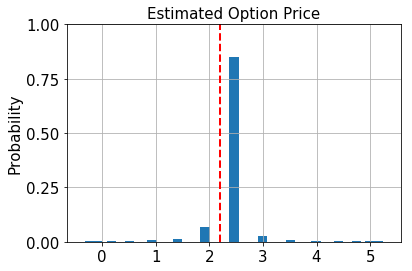

In [11]:
# plot estimated values for "a" (direct result of amplitude estimation, not rescaled yet)
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for fixed-income asset (after re-scaling and reversing the c_approx-transformation)
plt.bar(result['mapped_values'], result['probabilities'], width=3/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()